In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [5]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn
import torch
from torch.distributions import Normal

In [6]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [7]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [7]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=0, float_l=0, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie0.h5'),EarlyStopping(10)])

1: Train=442.2163403320312 Valid=391.4119476318359
2: Train=362.3932452392578 Valid=346.010869140625
3: Train=331.9170755004883 Valid=329.67456604003905
4: Train=323.1764352416992 Valid=323.30834106445315
5: Train=318.0535720825195 Valid=318.4128039550781
6: Train=314.04072540283204 Valid=314.60255432128906
7: Train=310.90707656860354 Valid=312.33531188964844
8: Train=308.5138830566406 Valid=309.6207165527344
9: Train=305.93710586547854 Valid=307.24237731933596
10: Train=303.90651733398437 Valid=305.4267803955078
11: Train=302.4751351928711 Valid=303.3624914550781
12: Train=300.5069970703125 Valid=302.0507208251953
13: Train=298.62565826416017 Valid=300.2758563232422
14: Train=296.89968612670896 Valid=298.6661456298828
15: Train=295.4555354309082 Valid=297.1927374267578
16: Train=293.90345184326173 Valid=295.99345245361326
17: Train=292.9413558959961 Valid=294.4258923339844
18: Train=291.28547958374025 Valid=293.1615408325195
19: Train=289.59864791870115 Valid=292.0491674804687
20: Tra

156: Train=249.2343098449707 Valid=251.99213500976563
157: Train=249.19577377319337 Valid=251.70539276123046
158: Train=249.37214996337892 Valid=251.71340789794922
159: Train=249.09968322753906 Valid=251.86307312011718
160: Train=248.86865936279298 Valid=251.62962799072267
161: Train=248.86343673706054 Valid=251.61407043457032
162: Train=249.17559661865235 Valid=251.69529693603516
163: Train=248.7037841796875 Valid=251.45269470214845
164: Train=248.85110580444336 Valid=251.5083380126953
165: Train=248.84646850585938 Valid=251.5471984863281
166: Train=248.39030212402344 Valid=251.6291827392578
167: Train=249.1187757873535 Valid=250.9451516723633
168: Train=248.73560043334962 Valid=251.20335021972656
169: Train=248.3168161010742 Valid=251.23661682128906
170: Train=248.21277236938477 Valid=251.18009826660156
171: Train=248.7515133666992 Valid=251.02141693115234
172: Train=248.69247833251953 Valid=250.6898629760742
173: Train=248.24485610961915 Valid=251.05256439208983
174: Train=247.91747

In [8]:
model.save('weights/Inferno_Test_exact_bm0.h5')

In [8]:
model.load('weights/Inferno_Test_exact_bm0.h5')

## BM 0

In [9]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [10]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,9,1.0
1,7,1.0
2,0,1.0
3,2,1.0
4,0,1.0


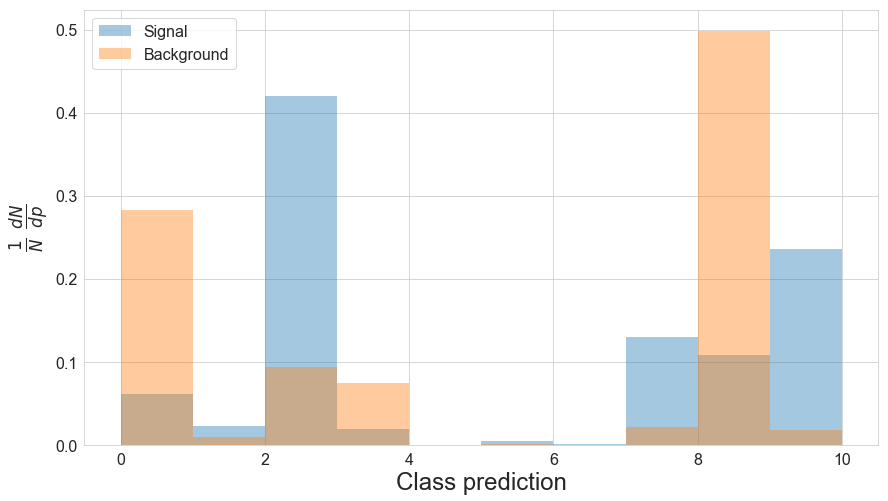

In [12]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [11]:
bin_preds(df)

In [14]:
df.head()

,pred,gen_target,pred_bin
0,2,1.0,2
1,8,1.0,8
2,9,1.0,9
3,2,1.0,2
4,2,1.0,2


In [12]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [16]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [17]:
f_s, f_b

(tensor([6.0600e-02, 2.2504e-02, 4.1953e-01, 1.8618e-02, 2.0000e-13, 4.0720e-03,
         5.1000e-04, 1.2976e-01, 1.0862e-01, 2.3578e-01]),
 tensor([2.8274e-01, 8.8620e-03, 9.3648e-02, 7.4998e-02, 2.0000e-13, 1.4780e-03,
         3.4800e-04, 2.0938e-02, 4.9871e-01, 1.8274e-02]))

In [18]:
asimov = (50*f_s)+(1000*f_b)

In [19]:
asimov, asimov.sum()

(tensor([2.8577e+02, 9.9872e+00, 1.1462e+02, 7.5929e+01, 2.1000e-10, 1.6816e+00,
         3.7350e-01, 2.7426e+01, 5.0414e+02, 3.0063e+01]), tensor(1049.9999))

In [20]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([25.37366486, 25.22743416, 25.08763885, 24.95342636, 24.82522964,
       24.70243645, 24.58556175, 24.47383308, 24.36780548, 24.26719093,
       24.17203331, 24.08185387, 23.99713135, 23.9172821 , 23.84251976,
       23.77259827, 23.70806503, 23.64806747, 23.59281349, 23.54236221,
       23.49651718, 23.45533371, 23.41851807, 23.38682556, 23.35892487,
       23.33572388, 23.31697845, 23.30194473, 23.29167366, 23.28512573,
       23.28309822, 23.28518295, 23.29141617, 23.30153847, 23.31576157,
       23.33370018, 23.35556602, 23.38158417, 23.41102028, 23.44424057,
       23.48137665, 23.52168846, 23.56611633, 23.61355019, 23.66519928,
       23.72015762, 23.77880096, 23.84093094, 23.9061985 , 23.97519875,
       24.04719925, 24.12277794, 24.20146179, 24.28343201, 24.3685112 ,
       24.45680237, 24.54838562, 24.64283943, 24.74086571, 24.84181786,
       24.94593811])

In [21]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [22]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

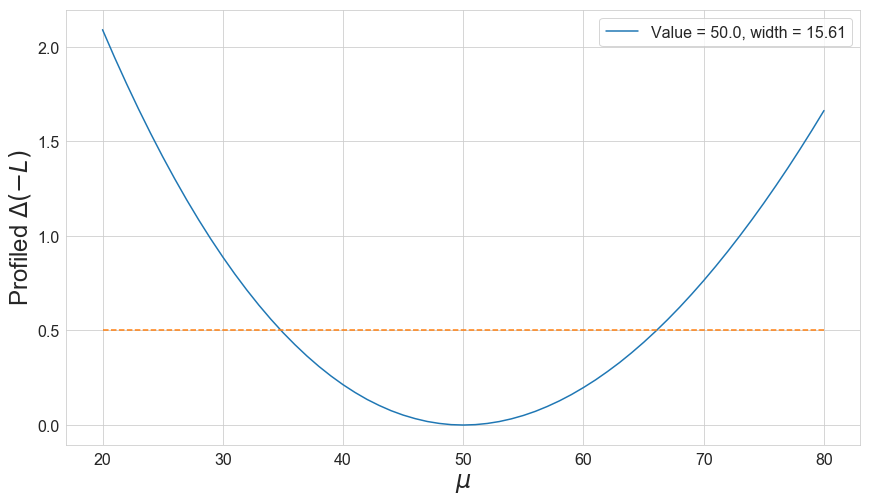

In [23]:
plot_likelihood(y-y.min())

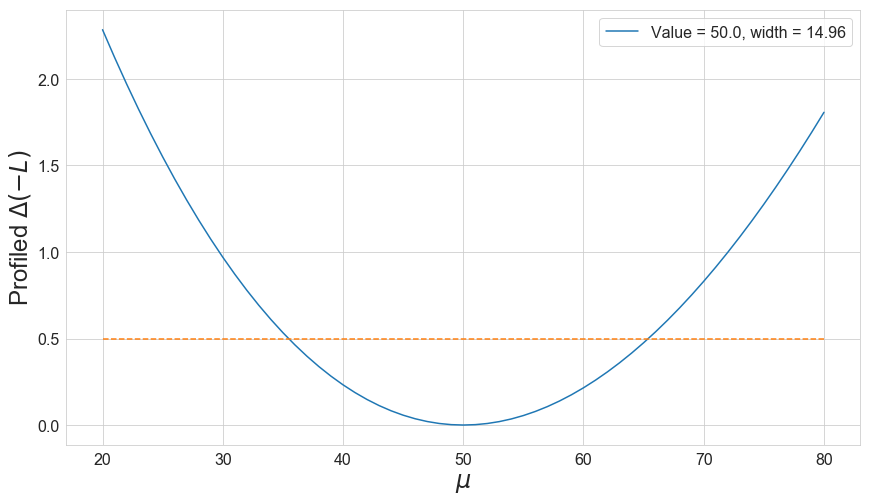

In [24]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [13]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [14]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [27]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,2,1.0,2,2,2,2,2,2,2,2,2,2,2
1,8,1.0,8,8,8,8,8,8,8,8,8,8,8
2,9,1.0,9,9,9,9,9,9,9,9,9,9,9
3,2,1.0,2,2,2,2,2,2,2,2,2,2,2
4,2,1.0,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999996,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999997,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999998,8,0.0,8,8,8,8,8,8,8,8,8,8,8


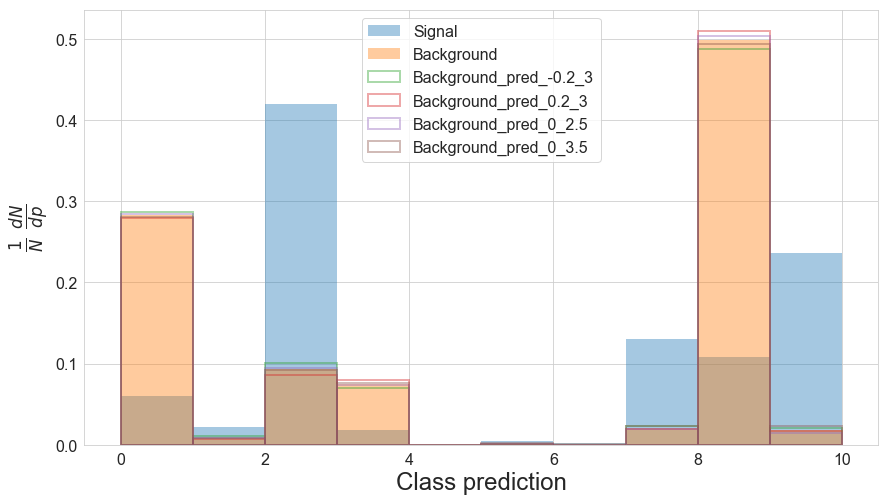

In [28]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([2.8806e-01, 1.0678e-02, 1.0117e-01, 6.8666e-02, 2.0000e-13, 9.6400e-04,
        4.6600e-04, 2.1348e-02, 4.9258e-01, 1.6068e-02])
tensor([2.8610e-01, 1.0644e-02, 1.0047e-01, 6.9868e-02, 2.0000e-13, 1.5020e-03,
        4.1200e-04, 2.3096e-02, 4.8772e-01, 2.0192e-02])
tensor([2.8419e-01, 1.0612e-02, 9.9266e-02, 7.1078e-02, 2.0000e-13, 2.2020e-03,
        4.1000e-04, 2.4962e-02, 4.8249e-01, 2.4784e-02])
tensor([2.8471e-01, 8.8960e-03, 9.4352e-02, 7.3796e-02, 2.0000e-13, 9.4000e-04,
        4.0200e-04, 1.9190e-02, 5.0357e-01, 1.4150e-02])
tensor([2.8274e-01, 8.8620e-03, 9.3648e-02, 7.4998e-02, 2.0000e-13, 1.4780e-03,
        3.4800e-04, 2.0938e-02, 4.9871e-01, 1.8274e-02])
tensor([2.8084e-01, 8.8300e-03, 9.2444e-02, 7.6208e-02, 2.0000e-13, 2.1780e-03,
        3.4600e-04, 2.2804e-02, 4.9348e-01, 2.2866e-02])
tensor([2.8086e-01, 7.3900e-03, 8.7218e-02, 7.8750e-02, 2.0000e-13, 8.8600e-04,
        3.5000e-04, 1.7152e-02, 5.1495e-01, 1.2446e-02])
tensor([2.7890e-01, 7.3560e-03, 8.6514e-0

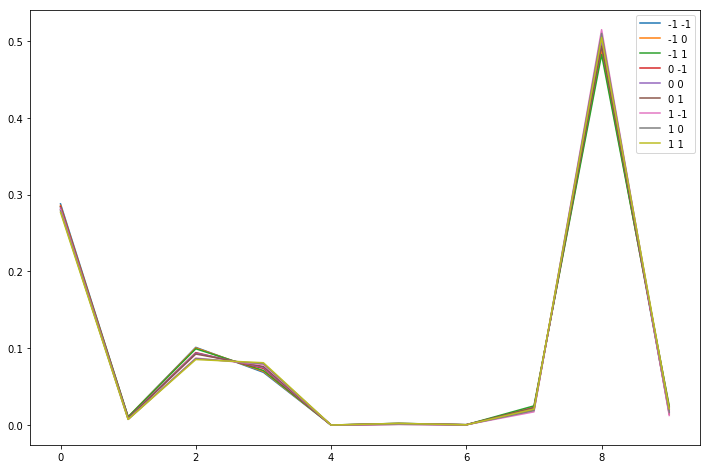

In [29]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [15]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [31]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [32]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [33]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [34]:
nll = to_np(nll)

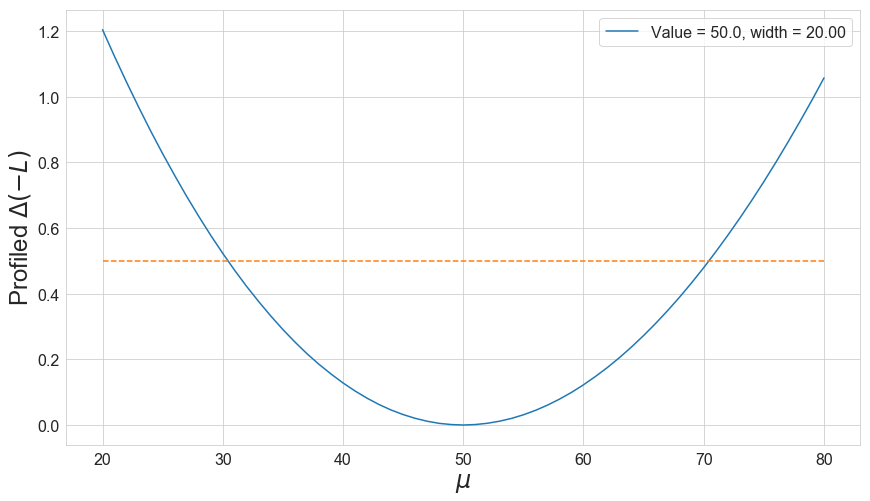

In [35]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [36]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [37]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.0737])
Linear regime: Mu 21.0, alpha tensor([1.0361])
Linear regime: Mu 77.0, alpha tensor([-1.0211])
Linear regime: Mu 78.0, alpha tensor([-1.0557])
Linear regime: Mu 79.0, alpha tensor([-1.0901])
Linear regime: Mu 80.0, alpha tensor([-1.1241])


In [38]:
nll = to_np(nll)

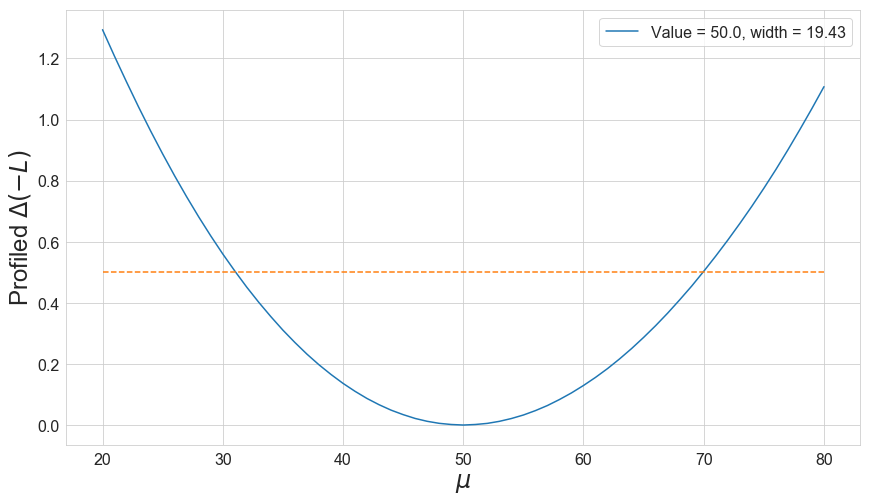

In [39]:
plot_likelihood(nll-nll.min())

## BM 2

In [40]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [41]:
nll = to_np(nll)

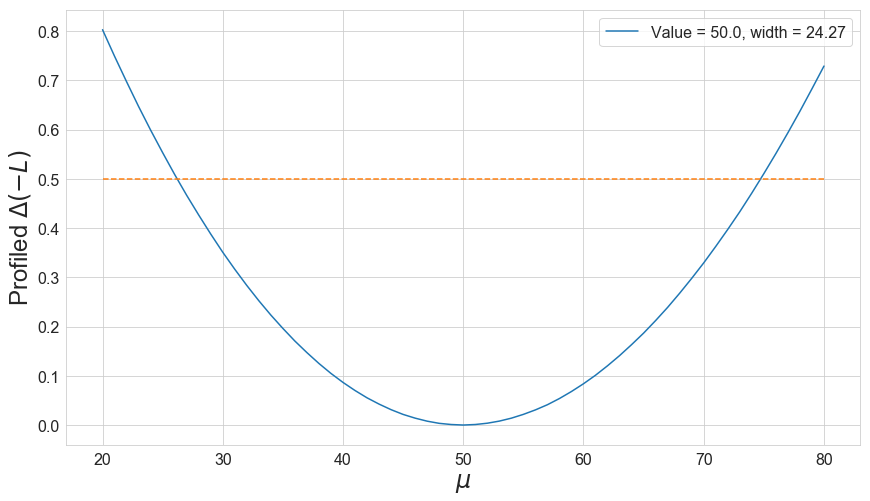

In [42]:
plot_likelihood(nll-nll.min())

## BM 3

In [16]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [17]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [18]:
nll = to_np(nll)

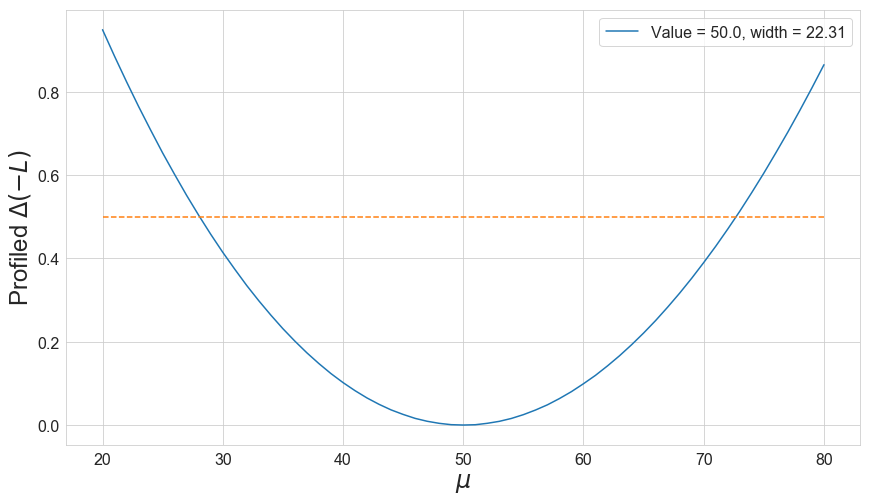

In [19]:
plot_likelihood(nll-nll.min())

## BM 4

In [20]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [21]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.6878,  0.7431, 26.5063])
Linear regime: Mu 21.0, alpha tensor([-0.6655,  0.7188, 25.5919])
Linear regime: Mu 22.0, alpha tensor([-0.6432,  0.6945, 24.6798])
Linear regime: Mu 23.0, alpha tensor([-0.6209,  0.6701, 23.7698])
Linear regime: Mu 24.0, alpha tensor([-0.5985,  0.6457, 22.8620])
Linear regime: Mu 25.0, alpha tensor([-0.5760,  0.6213, 21.9564])
Linear regime: Mu 26.0, alpha tensor([-0.5535,  0.5968, 21.0529])
Linear regime: Mu 27.0, alpha tensor([-0.5310,  0.5723, 20.1516])
Linear regime: Mu 28.0, alpha tensor([-0.5084,  0.5477, 19.2525])
Linear regime: Mu 29.0, alpha tensor([-0.4858,  0.5231, 18.3554])
Linear regime: Mu 30.0, alpha tensor([-0.4632,  0.4985, 17.4606])
Linear regime: Mu 31.0, alpha tensor([-0.4404,  0.4738, 16.5678])
Linear regime: Mu 32.0, alpha tensor([-0.4177,  0.4491, 15.6771])
Linear regime: Mu 33.0, alpha tensor([-0.3949,  0.4244, 14.7886])
Linear regime: Mu 34.0, alpha tensor([-0.3720,  0.3996, 13.9022])
Linear reg

In [22]:
nll = to_np(nll)

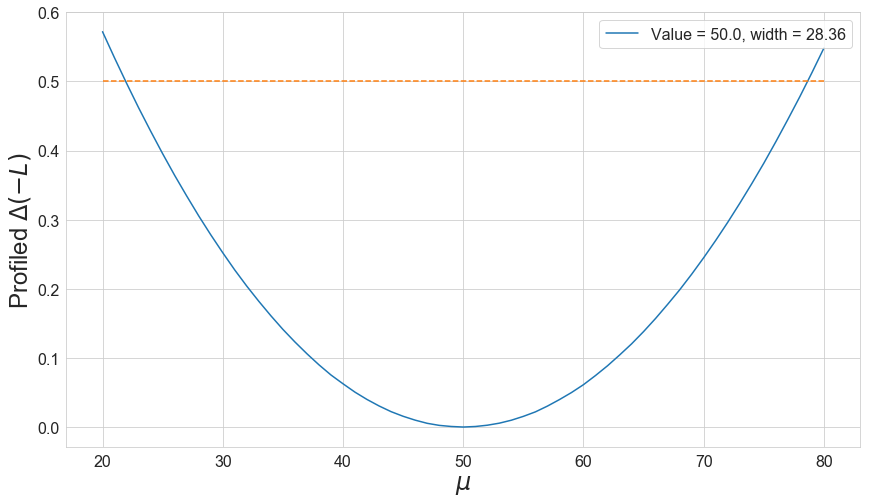

In [23]:
plot_likelihood(nll-nll.min())